# FAKE NEWS CLASSIFIATION

# 1. PROBLEM STATEMENT

* The authenticity of Information has become a longstanding issue affecting businesses and society, both for printed and digital media. On social networks, the reach and effects of information spread occur at such a fast pace and so amplified that distorted, inaccurate, or false information acquires a tremendous potential to cause real-world impacts, within minutes, for millions of users. Recently, several public concerns about this problem and some approaches to mitigate the problem were expressed. 

* In this project, you are given a dataset in the fake-news_data.zip folder. The folder contains a CSV files train_news.csv and you have to use the train_news.csv data to build a model to predict whether a news is fake or not fake. You have to try out different models on the dataset, evaluate their performance, and finally report the best model you got on the data and its performance.


# 2. DATA
* The data was provided by the flip robo technologies

# 3. EVALUATION

* Consider if our model can reach the accuracy over the `90%` we will continue with this project

# 4.FEATURES
> There are 6 columns in the dataset provided to you. The description of each of the column is given below:

* “id”:  Unique id of each news article
* “headline”:  It is the title of the news.
* “news”:  It contains the full text of the news article
* “Unnamed:0”:  It is a serial number
* “written_by”:  It represents the author of the news article
* “label”:  It tells whether the news is fake (1) or not fake (0).


# GETTING TOOLS READY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import string


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import word2vec
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

C:\Users\mussa\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Reading the data

In [2]:
train = pd.read_csv('train_news.csv')
train.drop('Unnamed: 0', axis=1, inplace=True)
train.head()

,id,headline,written_by,news,label
0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          20800 non-null  int64 
 1   headline    20242 non-null  object
 2   written_by  18843 non-null  object
 3   news        20761 non-null  object
 4   label       20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


**Checking for missing values**

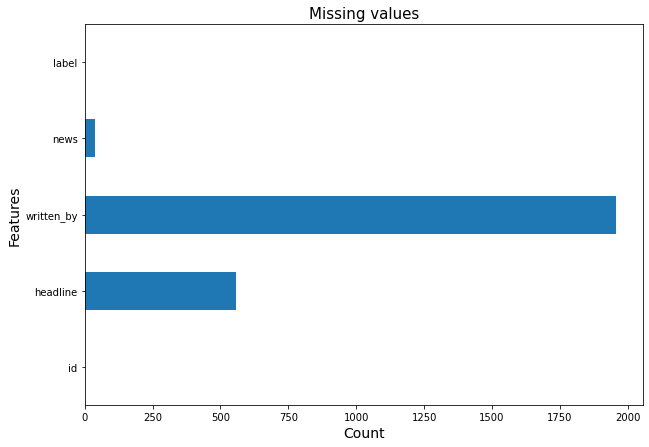

In [4]:
plt.figure(figsize = (10,7))
train.isna().sum().plot(kind = 'barh');
plt.title('Missing values', fontsize = 15)
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Features', fontsize = 14);

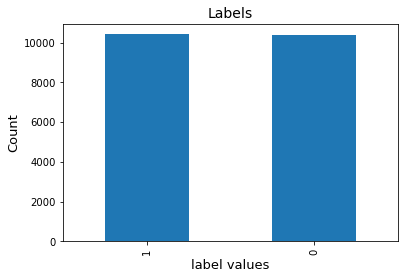

In [5]:
train['label'].value_counts().plot(kind = 'bar')
plt.title('Labels', fontsize = 14)
plt.xlabel('label values', fontsize = 13)
plt.ylabel('Count', fontsize = 13);

* The data is balanced

## Filling values

In [6]:
#checking for authors list if there are any repeated authors for filling the missing values
train.written_by.nunique()

4201

In [7]:
train.written_by.mode()

0    Pam Key
dtype: object

In [8]:
pam = train[['label']][train['written_by'] == 'Pam Key']
pam.value_counts()

label
0        242
1          1
dtype: int64

* If we fill the missing values with mode we might increase the label value 0

In [9]:
train.isna().sum()

id               0
headline       558
written_by    1957
news            39
label            0
dtype: int64

In [10]:
#checkimg for labels in missing authors value
lab_f_nan = train['label'][train['written_by'].isnull()]
lab_f_nan.value_counts()

1    1931
0      26
Name: label, dtype: int64

* As we got more labels as 1 in missing author value we cannot fill that value with mode

In [11]:
fake_auth = train[['written_by']][train['label']==1]
fake_auth.value_counts()[:10]

written_by                           
admin                                    193
Pakalert                                  86
Eddy Lavine                               85
Starkman                                  84
Gillian                                   82
Alex Ansary                               82
Editor                                    81
noreply@blogger.com (Alexander Light)     80
Dave Hodges                               77
Anonymous                                 77
dtype: int64

* As we can see top 10 authors here will try to fill the nan values with these authors 

In [12]:
train['written_by'][train['label']==0].mode()

0    Pam Key
dtype: object

**Filling the missing values where label is 0**

In [13]:
cond = train['label'] == 0
train['written_by'] = train['written_by'].fillna(cond.map({True : 'Pam Key'}))

In [14]:
train['label'][train['written_by'].isnull()].value_counts()

1    1931
Name: label, dtype: int64

**Filling the missing values where label is 1 with 3 differnt authors**

In [15]:
miss = train['written_by'].isna()
nans = sum(miss)
replace = random.choices(['admin', 'Editor', 'noreply'],
                         weights=[.2, .4, .4],
                         k=nans)
train.loc[miss, 'written_by'] = replace
train['written_by'].isna().sum()

0

**Now dropping the nan values as we cant fill the head line and the news with mode as they vary** 

In [16]:
train.dropna(inplace = True)
train.isna().sum()

id            0
headline      0
written_by    0
news          0
label         0
dtype: int64

##  Checking for duplicates

In [17]:
train.head()

,id,headline,written_by,news,label
0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


In [18]:
train['news'][train['news'].duplicated()][train['label'] == 1].count()

335

In [19]:
train['news'][train['news'].duplicated()][train['label'] == 0].count()

0

In [20]:
train['headline'][train['headline'].duplicated()][train['label'] == 0].count()

6

In [21]:
train['headline'][train['headline'].duplicated()][train['label'] == 1].count()

433

In [22]:
Dups = train.copy()
Dups.head()

,id,headline,written_by,news,label
0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


In [23]:
Dups.reset_index(inplace = True)

In [24]:
Dups.drop_duplicates(subset = ['headline', 'news'],
                    keep = 'last',
                    inplace = True)

## Preprocessing the data

In [25]:
#searching if any email address in news
emails = []
news = Dups['news'].astype('str')
email = [re.findall(r'[\w\.-]+@[\w\.-]+', n) for n in news]
for mail in email:
    if mail == []:
        continue
    else:
        emails.append(mail)
len(emails)

1027

In [26]:
#checking for any phone numbers
phnos = []
Phno = [re.findall(r' ^(?:\+\d{1,3}|0\d{1,3}|00\d{1,2})?(?:\s?\(\d+\))?(?:[-\/\s.]|\d)+$', n) for n in news]
for ph in Phno:
    if ph == []:
        continue
    else:
        phnos.append(ph)
phnos    

[]

In [27]:
#checking for currency symbols 
curr = []
currency = [re.findall(r'$|\€|\£|\₹',n) for n in news]
for c in currency:
    if c == ['']:
        continue
    else:
        curr.append(c)
len(curr)   

811

In [28]:
stp_wrds = stopwords.words('english')
lemmatizer = WordNetLemmatizer()


def preprocess_data(data):

    #this lowers the alphabets
    data = data.str.lower()

    #replacing the email address
    data = data.str.replace(r'[\w\.-]+@[\w\.-]+', 'emailaddress')

    #replacing the currency symbols
    data = data.str.replace(r'$|\€|\£|\₹', 'currency')

    #removing the punctions and filling with white spaces
    data = data.str.replace(r'[^a-zA-Z0-9]', ' ') 

    #removing the numeric characters
    data = data.str.replace(r'[0-9]', '')

    #replacing the trailing white spaces
    data = data.replace('  ', '')

    #removing stopwords
    data = data.apply(
            lambda x: ' '.join(word for word in x.split() if word not in stp_wrds))

    #lemmatizing words
    data = data.apply(lambda x: ' '.join(
            lemmatizer.lemmatize(word) for word in word_tokenize(x)))

    return data

In [29]:
Dups['cleaned_news'] = preprocess_data(Dups['news'])

In [30]:
Dups['Length'] = Dups['news'].str.len()

In [31]:
Dups.head()

,index,id,headline,written_by,news,label,cleaned_news,Length
0,0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,washington sonny perdue telling georgian growi...,7936
1,1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0,houston venezuela plan tactical approach desig...,6112
2,2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0,sunday abc week discussing republican plan rep...,425
3,3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0,augusta beleaguered republican governor maine ...,6516
4,4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1,finian cunningham written extensively internat...,9164


In [32]:
Dups['Cleaned_length'] = Dups['cleaned_news'].str.len()

In [33]:
def preprocess_head(data):
    data = data.replace(r'[^a-zA-Z0-9]', ' ')
    data = data.str.lower()
    return data

In [34]:
Dups['cleaned_headline'] = preprocess_head(Dups['headline'])
Dups['cleaned_by'] = preprocess_head(Dups['written_by'])

In [35]:
Dups.head()

,index,id,headline,written_by,news,label,cleaned_news,Length,Cleaned_length,cleaned_headline,cleaned_by
0,0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,washington sonny perdue telling georgian growi...,7936,5255,ethics questions dogged agriculture nominee as...,eric lipton and steve eder
1,1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0,houston venezuela plan tactical approach desig...,6112,3948,u.s. must dig deep to stop argentina’s lionel ...,david waldstein
2,2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0,sunday abc week discussing republican plan rep...,425,275,cotton to house: ’do not walk the plank and vo...,pam key
3,3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0,augusta beleaguered republican governor maine ...,6516,4334,"paul lepage, besieged maine governor, sends co...",jess bidgood
4,4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1,finian cunningham written extensively internat...,9164,6522,a digital 9/11 if trump wins,finian cunningham


In [36]:
df = Dups.copy()

In [37]:
df['word_count_n'] = df['news'].apply(lambda x : len(str(x).split()))

In [38]:
df['word_count_cn'] = df['cleaned_news'].apply(lambda x : len(str(x).split()))

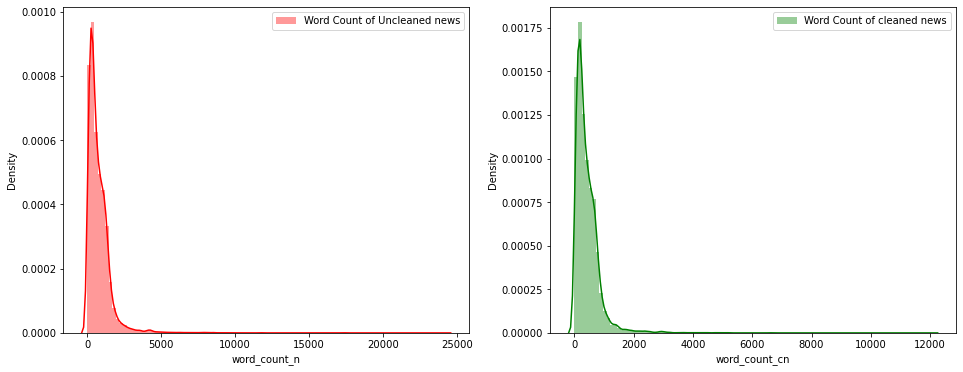

In [39]:
# Visualizing the spread of word count before and after cleaning
fig, ax = plt.subplots(1,2, figsize = (16, 6))

sns.distplot(df['word_count_n'],color = 'r', ax = ax[0], bins = 100, label= 'Word Count of Uncleaned news')
ax[0].legend();

sns.distplot(df['word_count_cn'], color = 'g', ax = ax[1], bins = 100, label = 'Word Count of cleaned news')
ax[1].legend();

## Visualization of words before cleaning for fake news

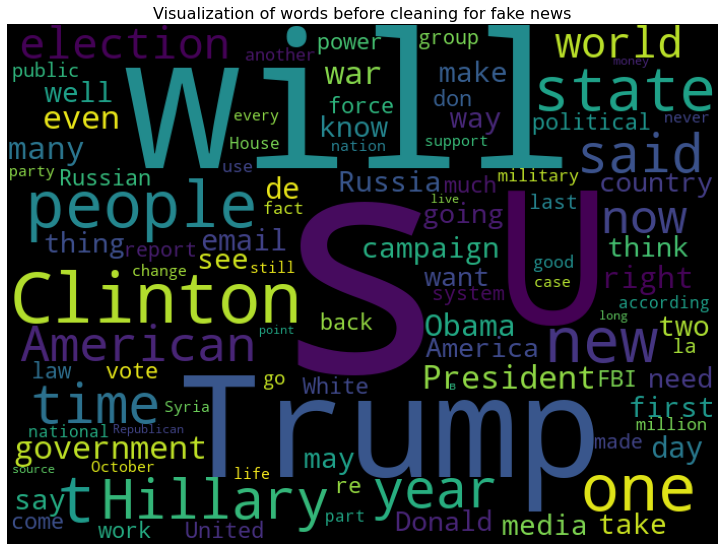

In [46]:
Fake = df['news'][df['label'] == 1]
news = WordCloud(width = 700, height = 512, max_words = 100, prefer_horizontal=1, collocations= False, ).generate(' '.join(Fake))
plt.figure(figsize = (15,8))
plt.imshow(news)
plt.title('Visualization of words before cleaning for fake news', fontsize = 16)
plt.tight_layout()
plt.axis('off');

## Visualization of words after cleaning fake news

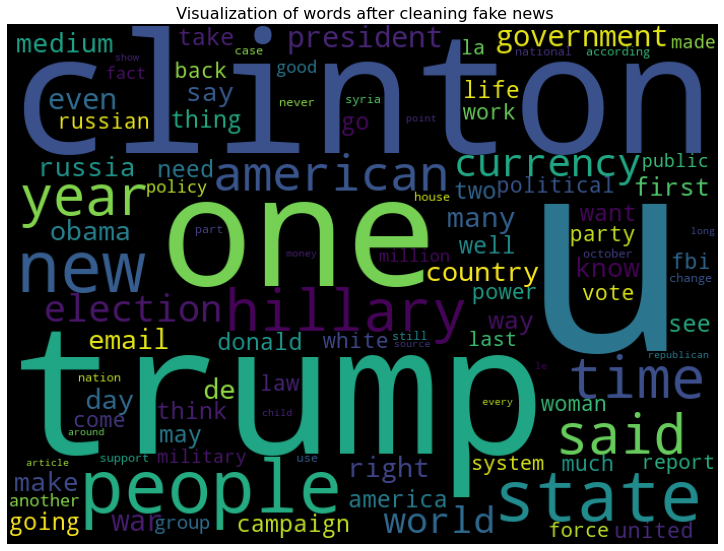

In [45]:
fake_af = df['cleaned_news'][df['label'] == 1]
news1 = WordCloud(width = 700, height = 512, max_words = 100, prefer_horizontal=1, collocations= False, ).generate(' '.join(fake_af))
plt.figure(figsize = (15,8))
plt.imshow(news1)
plt.title(' Visualization of words after cleaning fake news', fontsize = 16)
plt.tight_layout()
plt.axis('off');

## Visualization of words before cleaning in real news

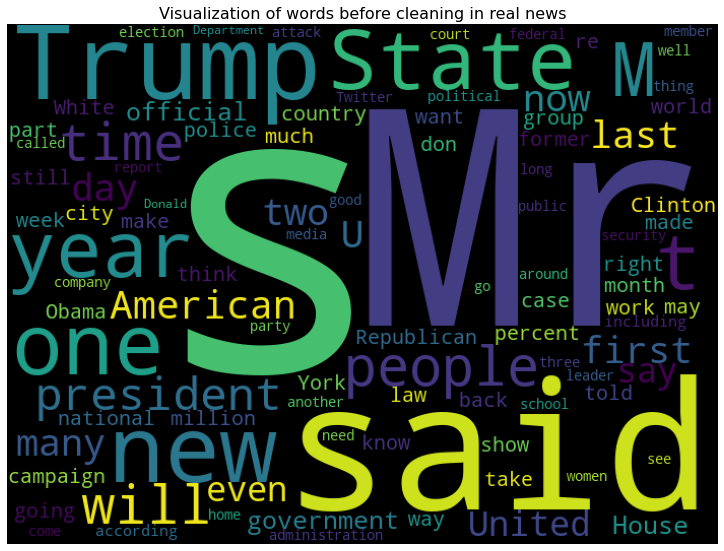

In [49]:
real = df['news'][df['label'] == 0]
real_ = WordCloud(width = 700, height = 512, max_words = 100, prefer_horizontal = 1, collocations = False).generate(' '.join(real))
plt.figure(figsize = (15,8))
plt.imshow(real_)
plt.title('Visualization of words before cleaning in real news', fontsize = 16)
plt.tight_layout()
plt.axis('off');

## Visualization of words after cleaning in real news

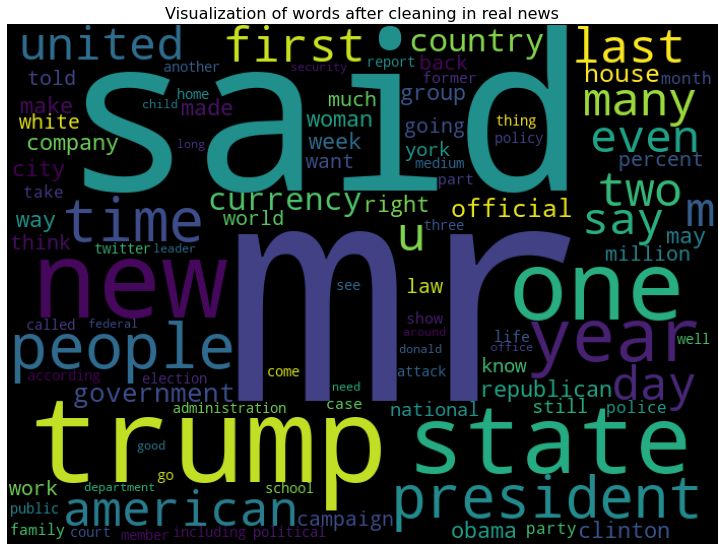

In [50]:
real = df['cleaned_news'][df['label'] == 0]
real_ = WordCloud(width = 700, height = 512, max_words = 100, prefer_horizontal = 1, collocations = False).generate(' '.join(real))
plt.figure(figsize = (15,8))
plt.imshow(real_)
plt.title('Visualization of words after cleaning in real news', fontsize = 16)
plt.tight_layout()
plt.axis('off');

In [51]:
df.to_csv('Final.csv', index = False)
csv = pd.read_csv('Final.csv')
csv.head()

,index,id,headline,written_by,news,label,cleaned_news,Length,Cleaned_length,cleaned_headline,cleaned_by,word_count_n,word_count_cn
0,0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,washington sonny perdue telling georgian growi...,7936,5255,ethics questions dogged agriculture nominee as...,eric lipton and steve eder,1342,724
1,1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0,houston venezuela plan tactical approach desig...,6112,3948,u.s. must dig deep to stop argentina’s lionel ...,david waldstein,1050,575
2,2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0,sunday abc week discussing republican plan rep...,425,275,cotton to house: ’do not walk the plank and vo...,pam key,80,42
3,3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0,augusta beleaguered republican governor maine ...,6516,4334,"paul lepage, besieged maine governor, sends co...",jess bidgood,1103,592
4,4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1,finian cunningham written extensively internat...,9164,6522,a digital 9/11 if trump wins,finian cunningham,1442,859
